# Time Series Model for Annual Immigration into the USA Using Python
### David Lowe
### December 18, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

SUMMARY: The purpose of this project is to construct a time series prediction model and document the end-to-end steps using a template. The Annual Immigration into the USA dataset is a time series situation where we are trying to forecast future outcomes based on past data points.

INTRODUCTION: The problem is to forecast the annual number of people immigrating to the United States. The dataset describes a time-series of people (in thousands) over 143 years (1820-1962), and there are 143 observations. We used the first 80% of the observations for training and testing various models while holding back the remaining observations for validating the final model.

ANALYSIS: The baseline prediction (or persistence) for the dataset resulted in an RMSE of 38312. After performing a grid search for the most optimal ARIMA parameters, the final ARIMA non-seasonal order was (0, 1, 2). Furthermore, the chosen model processed the validation data with an RMSE of 61789, which was significantly worse than the baseline model. We can partly attribute the loss in the model's prediction performance to the exceptionally low immigration during the 1930s, the great depression era in the United States.

CONCLUSION: For this dataset, the chosen ARIMA model did not achieve a satisfactory result. We should acquire more data or figure out how to account for the external factors (economy and so on) in our time series modeling effort.

Dataset Used: Annual immigration into the United States, 1820-1962

Dataset ML Model: Time series forecast with numerical attributes

Dataset Reference: Rob Hyndman and Yangzhuoran Yang (2018). tsdl: Time Series Data Library. v0.1.0. https://pkg.yangzhuoranyang./tsdl/.

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end
* Explore data cleaning and transformation options
* Explore various algorithms for baselining the model performance
* Explore tuning techniques for improving the model performance

A time series predictive modeling project genrally can be broken down into about five major tasks:

1. Define Problem and Acquire Data
2. Inspect and Explore Data
3. Clean and Pre-Process Data
4. Fit and Evaluate Models
5. Finalize Model

## Section 1. Define Problem and Acquire Data

### 1.a) Load Libraries

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib
import pmdarima as pm
from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### 1.b) Set up the controlling parameters and functions

In [3]:
# Create the random seed number for reproducible results
seedNum = 888

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

In [4]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python ARIMA Time Series Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [5]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

Since the dataset is not current, this means that we cannot easily collect updated data to validate the model. Therefore, we will withhold a portion of the data towards the end from analysis and model selection. This very segment of data will be used to validate the final model.

In [6]:
startTimeScript = datetime.now()

In [7]:
# load the dataset and the necessary data structure
time_series = pd.read_csv('https://github.com/daines-analytics/datasets-public/raw/master/time-series-data-library/tsdl224.csv', index_col='idx', parse_dates=True)

# Sample code for subsetting the time-series data
# time_series = original_series['1986':'1990']

In [8]:
target_col = time_series.columns[0]
lower_bound = 'lower ' + target_col
upper_bound = 'upper ' + target_col
print('The target column of the time series is:', target_col)
print('The forecast boundary columns are:', lower_bound, '&', upper_bound)

The target column of the time series is: values
The forecast boundary columns are: lower values & upper values


In [9]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 1820-01-01 to 1962-01-01
Data columns (total 1 columns):
values    143 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [10]:
time_series.head(10)

,values
idx,
1820-01-01,8385
1821-01-01,9127
1822-01-01,6911
1823-01-01,6354
1824-01-01,7912
1825-01-01,10199
1826-01-01,10837
1827-01-01,18875
1828-01-01,27382


In [11]:
time_series.tail(10)

,values
idx,
1953-01-01,170434
1954-01-01,208177
1955-01-01,237790
1956-01-01,321625
1957-01-01,326867
1958-01-01,253265
1959-01-01,260686
1960-01-01,265398
1961-01-01,271344


In [12]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2. Inspect and Explore Data

In [13]:
if (notifyStatus): email_notify("Data Inspection and Exploration has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [14]:
# Summary statistics of time series
print(time_series.describe())

              values
count     143.000000
mean   255007.559441
std    212145.977629
min      6354.000000
25%     78977.500000
50%    229299.000000
75%    334689.000000
max    878587.000000


### 2.b) Line Plot of the Time Series Data

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:

* Whether the trend appears to be level around the mean
* Whether there appear to be any obvious outliers

The ARIMA(p,d,q) model requires three parameters and assumes that we are working with a stationary time series.

The ADF results should show that the test statistic value is smaller than the critical value at 5% if the time series is stationary. This suggests that we can reject the null hypothesis (i.e. a low probability that the result is a statistical fluke).

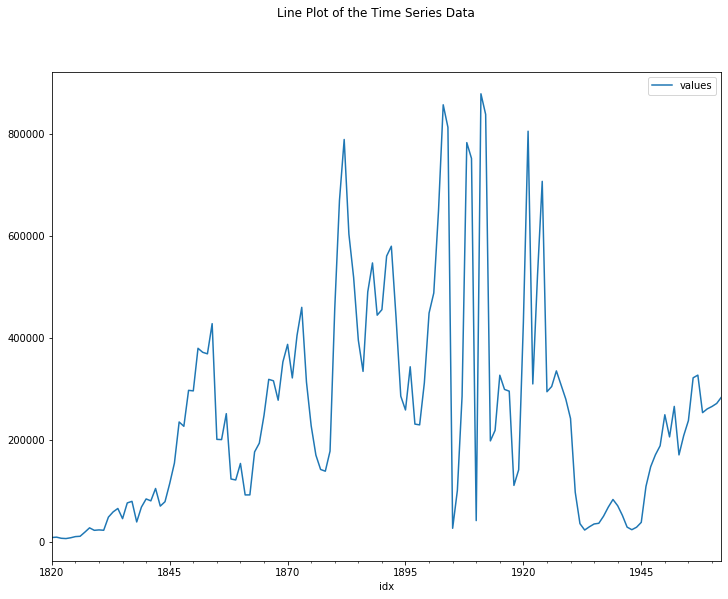

In [15]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Time Series Data')
time_series.plot(ax=ax)
plt.show()

### 2.c) Histogram and Density Plots of the Time Series Data

Reviewing plots of the density of observations can provide further insight into the structure of the data. Some observations from the plots can include:

* Whether the distribution is Gaussian
* Whether the distribution has a long tail and may suggest the need for data transformation

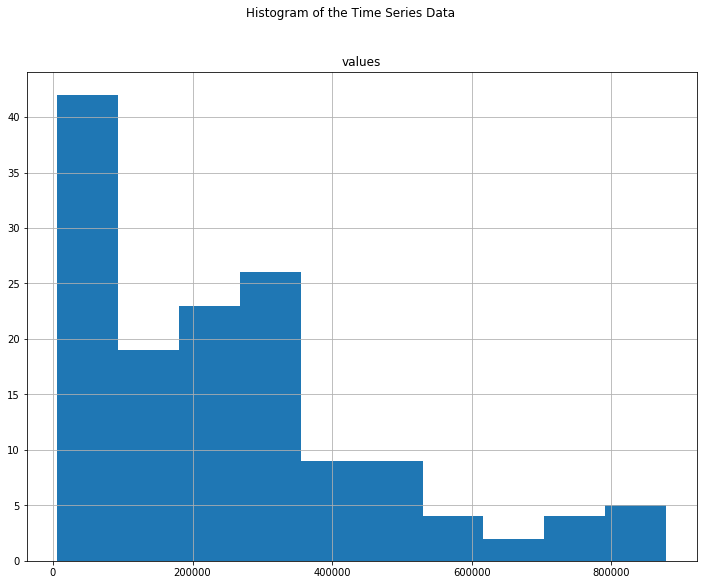

In [16]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Histogram of the Time Series Data')
time_series.hist(ax=ax)
plt.show()

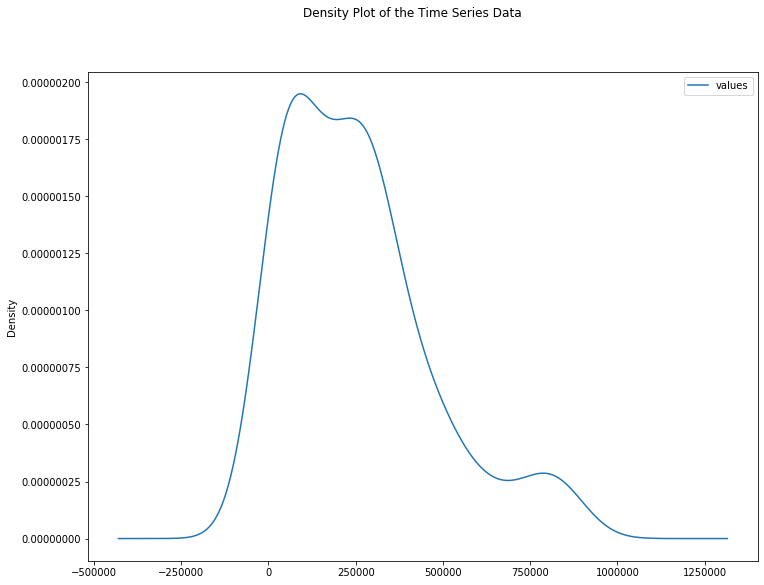

In [17]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Density Plot of the Time Series Data')
time_series.plot(kind='kde', ax=ax)
plt.show()

### 2.d) Box and Whisker Plots of the Time Series Data

We can group or aggregate the data and get a better idea of the spread of observations. Some observations from reviewing the plot can include:

* Whether the median values for each grouping shows any significant trend
* Whether the spread, or middle 50% of the data, shows any significant variability
* Whether there are outliers in some grouping

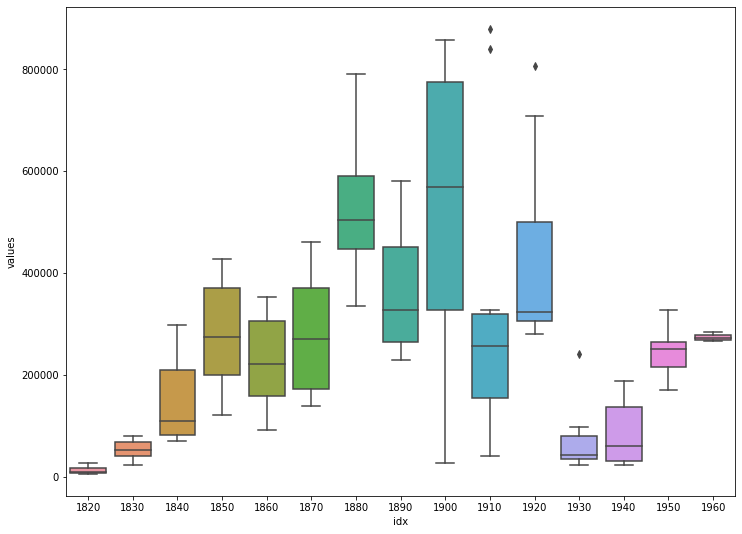

In [18]:
# boxplots of time series
fig, ax = plt.subplots(figsize=(12,9))
squeezed = time_series.squeeze()
sns.boxplot(((squeezed.index.year//10)*10), squeezed, ax=ax)
plt.show()

In [19]:
if (notifyStatus): email_notify("Data Inspection and Exploration completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3. Data Transformation and Stationarity Tests

In [20]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### Section 3.a) Data Transformation

In [21]:
# Resampling the time series into monthly average for the ease of modeling
# original_series = time_series
# resample = original_series.resample('M')
# time_series = resample.mean()
# time_series.head(10)

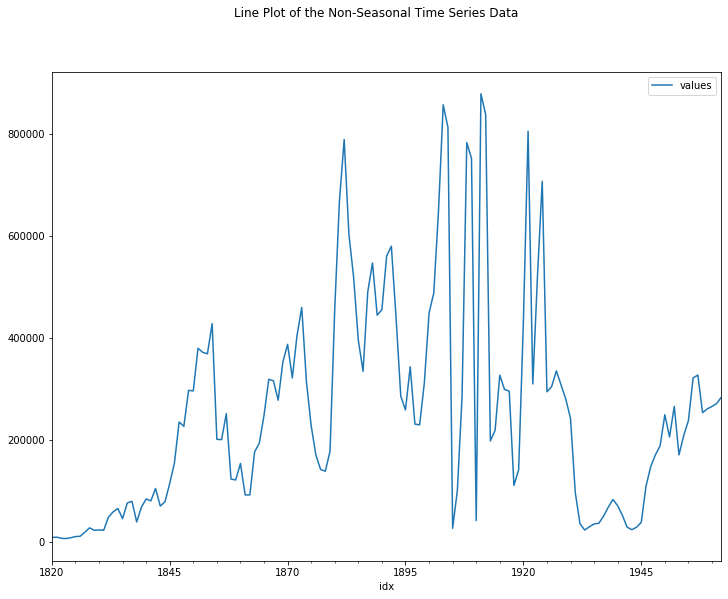

In [22]:
# Line plots of the transformed time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Non-Seasonal Time Series Data')
time_series.plot(ax=ax)
plt.show()

### Section 3.b) Test for Stationarity

In [23]:
# Check if stationary
result = adfuller(time_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.159209
p-value: 0.221382
Critical Test Statistics Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


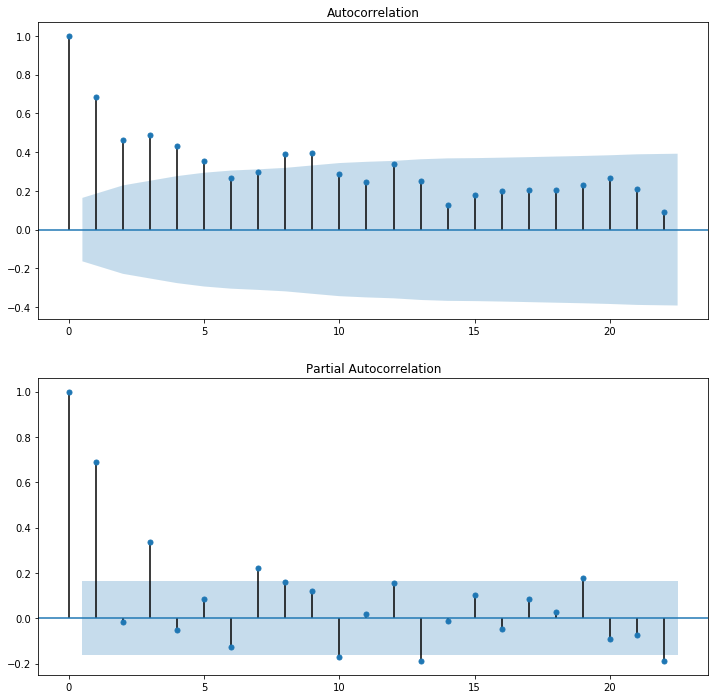

In [24]:
# ACF and PACF plots of the time series data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(time_series, ax=ax1)
plot_pacf(time_series, ax=ax2)
plt.show()

### 3.c) Test for Stationarity of Non-Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

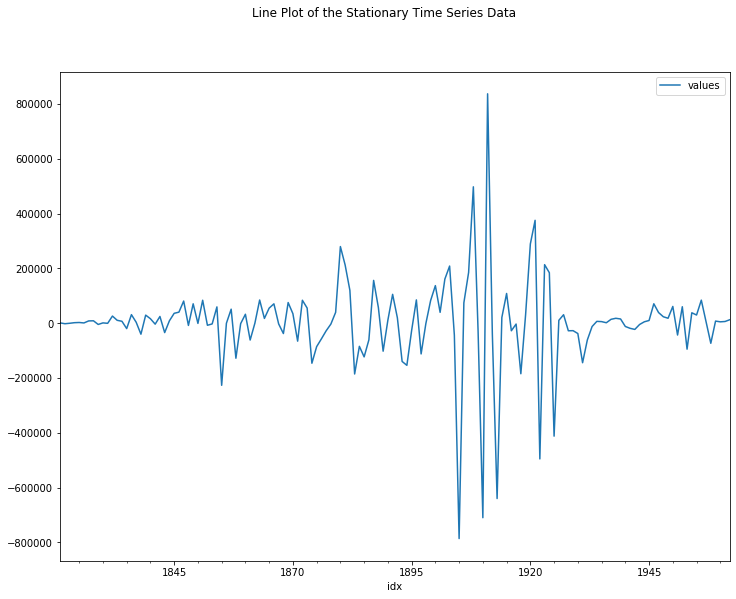

In [25]:
# Create a differenced series
stationary_ns = time_series.diff().dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Time Series Data')
stationary_ns.plot(ax=ax)
plt.show()

In [26]:
# Check for stationarity
result = adfuller(stationary_ns[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.122824
p-value: 0.000888
Critical Test Statistics Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


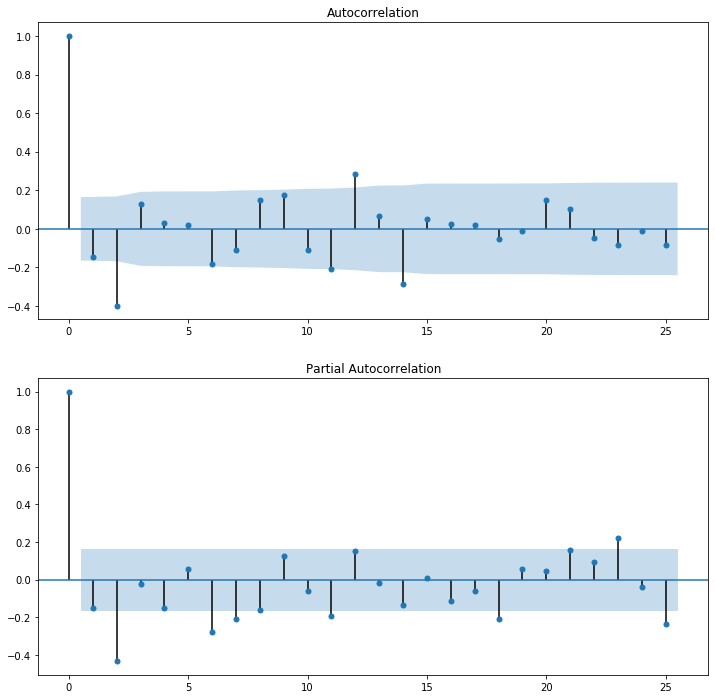

In [27]:
# ACF and PACF plots of the stationary time series
lags = 25
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ns, lags=lags, ax=ax1)
plot_pacf(stationary_ns, lags=lags, ax=ax2)
plt.show()

### 3.d) Seasonal Decomposition for Seasonal Time Series Data

In [28]:
# Set the initial seasonal frequency parameter
seasonal_freq = 0

### 3.e) Test for Stationarity of Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [29]:
# Not applicable for this dataset

In [30]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 4. Fit and Evaluate Models

In this section, we will develop Autoregressive Integrated Moving Average or ARIMA models for the problem. We will first establish a persistent model. Next we will use a grid search approach to look for an optimal ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model.

* Establish the Persistent Model
* Automatically Configure the ARIMA
* Review Residual Errors

In [31]:
if (notifyStatus): email_notify("Model Fitting and Evaluation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Establish the Persistent Model

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

#### 4.a.iii) Establish the Persistent Model as Baseline

In [32]:
# Prepare and evaluate a persistence model
X = time_series.values
X = X.astype('float32')
train_pct = 0.80
train_size = int(len(X) * train_pct)
test_size = len(X) - train_size
train_ts, test_ts = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train_ts]
predictions = list()
for i in range(len(test_ts)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test_ts[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# Calculate performance
rmse = math.sqrt(mean_squared_error(test_ts, predictions))
print('RMSE for the persistent model is: %.3f' % rmse)

>Predicted=23068.000, Expected=29470
>Predicted=29470.000, Expected=34956
>Predicted=34956.000, Expected=36329
>Predicted=36329.000, Expected=50244
>Predicted=50244.000, Expected=67895
>Predicted=67895.000, Expected=82998
>Predicted=82998.000, Expected=70756
>Predicted=70756.000, Expected=51776
>Predicted=51776.000, Expected=28781
>Predicted=28781.000, Expected=23725
>Predicted=23725.000, Expected=28551
>Predicted=28551.000, Expected=38119
>Predicted=38119.000, Expected=108721
>Predicted=108721.000, Expected=147292
>Predicted=147292.000, Expected=170570
>Predicted=170570.000, Expected=188317
>Predicted=188317.000, Expected=249187
>Predicted=249187.000, Expected=205717
>Predicted=205717.000, Expected=265520
>Predicted=265520.000, Expected=170434
>Predicted=170434.000, Expected=208177
>Predicted=208177.000, Expected=237790
>Predicted=237790.000, Expected=321625
>Predicted=321625.000, Expected=326867
>Predicted=326867.000, Expected=253265
>Predicted=253265.000, Expected=260686
>Predicted=

### 4.b) Grid Search of ARIMA Hyperparameters

We want to find a model that can do better than the persistence model on this dataset. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values.

In [33]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [34]:
# Set the initial P, D, and Q order parameters for non-seasonal ARIMA modeling
start_p = 0
start_d = None
start_q = 0
max_p = 5
max_d = 2
max_q = 5

In [35]:
# Set the initial P, D, and Q order parameters for seasonal ARIMA modeling
start_P = 0
start_D = None
start_Q = 0
max_P = 2
max_D = 1
max_Q = 2

In [36]:
# Testing the time series data for suggestions on the differencing term
start_d = pm.arima.ndiffs(train_ts)
print('The suggested non-seasonal differencing term is:', start_d)
if (seasonal_freq != 0):
    start_D = pm.arima.nsdiffs(train_ts, m = seasonal_freq)
    print('The suggested seasonal differencing term is:', start_D)

The suggested non-seasonal differencing term is: 1


In [37]:
print('The initial non-seasonal parameters are: p =', start_p, '| d =', start_d, '| q =', start_q)
print('The maximum non-seasonal parameters are: max_p =', max_p, '| max_d =', max_d, '| max_q =', max_q)
if (seasonal_freq != 0):
    print('The initial seasonal parameters are: P =', start_P, '| D =', start_D, '| Q =', start_Q, '| m =', seasonal_freq)
    print('The maximum seasonal parameters are: max_P =', max_P, '| max_D =', max_D, '| max_Q =', max_Q)

The initial non-seasonal parameters are: p = 0 | d = 1 | q = 0
The maximum non-seasonal parameters are: max_p = 5 | max_d = 2 | max_q = 5


In [38]:
# Do an automated stepwise search of ARIMA parameters
if (seasonal_freq == 0):
    stepwise_results = pm.auto_arima(train_ts, seasonal = False, stepwise = True, trace = True, suppress_warnings = True, random_state = seedNum)
else:
    stepwise_results = pm.auto_arima(train_ts, seasonal = True, m = seasonal_freq, stepwise = True, trace = True, suppress_warnings = True, random_state = seedNum)

Fit ARIMA: order=(2, 1, 2); AIC=3035.812, BIC=3052.177, Fit time=0.441 seconds
Fit ARIMA: order=(0, 1, 0); AIC=3066.840, BIC=3072.295, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=3066.365, BIC=3074.547, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 1); AIC=3058.372, BIC=3066.555, Fit time=0.145 seconds
Fit ARIMA: order=(1, 1, 2); AIC=3034.485, BIC=3048.122, Fit time=0.312 seconds
Fit ARIMA: order=(1, 1, 1); AIC=3045.290, BIC=3056.199, Fit time=0.411 seconds
Fit ARIMA: order=(1, 1, 3); AIC=3034.743, BIC=3051.108, Fit time=1.266 seconds
Fit ARIMA: order=(2, 1, 3); AIC=3037.591, BIC=3056.682, Fit time=0.765 seconds
Fit ARIMA: order=(0, 1, 2); AIC=3033.683, BIC=3044.592, Fit time=0.409 seconds
Fit ARIMA: order=(0, 1, 3); AIC=3034.795, BIC=3048.432, Fit time=0.232 seconds
Total fit time: 4.033 seconds


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  113
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1512.841
Method:                       css-mle   S.D. of innovations         156844.013
Date:                Wed, 11 Dec 2019   AIC                           3033.683
Time:                        20:32:20   BIC                           3044.592
Sample:                             1   HQIC                          3038.110
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2494.8629   2608.516      0.956      0.341   -2617.734    7607.460
ma.L1.D.y     -0.2308      0.087     -2.651      0.009      -0.401      -0.060
ma.L2.D.y     -0.6101      0.089     -6.872      0.0

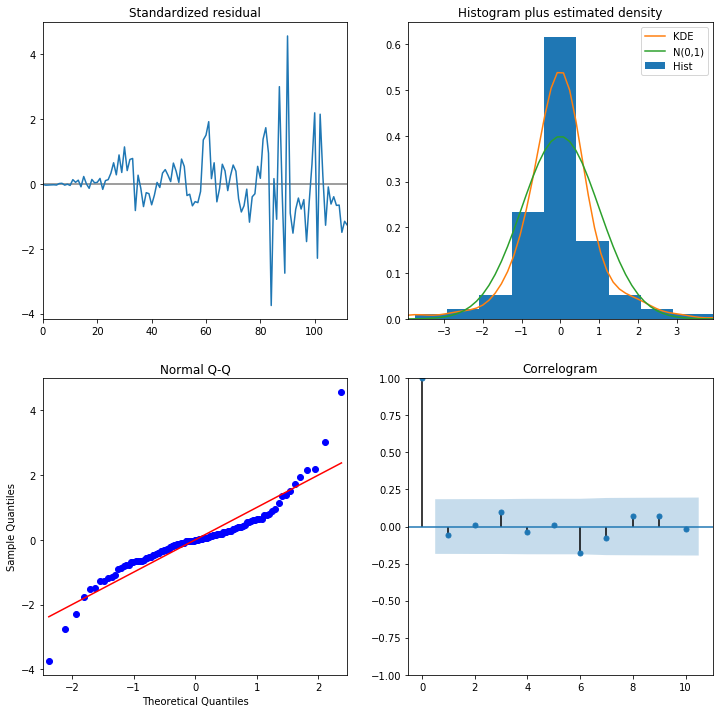

In [39]:
# Summarize residual errors for the automated grid search ARIMA model
print(stepwise_results.summary())
stepwise_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [40]:
if (notifyStatus): email_notify("ARIMA automated stepwise search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [41]:
# Do an automated random search of ARIMA parameters
n_fits = int(max_p * max_d * max_q * max_P * max_D * max_Q * 0.30)
if (seasonal_freq == 0):
    randgrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = False, stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)
else:
    randgrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = True, m = seasonal_freq, start_P = start_P, D = start_D, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
                                     stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)

Fit ARIMA: order=(5, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1); AIC=3046.873, BIC=3060.510, Fit time=0.173 seconds
Fit ARIMA: order=(2, 1, 3); AIC=3037.591, BIC=3056.682, Fit time=0.766 seconds
Fit ARIMA: order=(5, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(5, 1, 1); AIC=3047.565, BIC=3069.384, Fit time=0.791 seconds
Fit ARIMA: order=(4, 1, 0); AIC=3046.353, BIC=3062.717, Fit time=0.188 seconds
Fit ARIMA: order=(3, 1, 3); AIC=3039.495, BIC=3061.314, Fit time=1.335 seconds
Fit ARIMA: order=(3, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 4); AIC=3059.570, BIC=3086.844, Fit time=2.253 seconds
Fit ARIMA: order=(0, 1, 4); AIC=3035.593, BIC=3051.957, Fit time=1.114 seconds
Fit ARIMA: order=(1, 1, 4); AIC=3037.122, BIC=3056.214, Fit time=0.623 seconds
Fit ARIMA: order=(1, 1, 3); AIC=3034.743, BIC=3051.108, Fit time=1.269 seconds
Fit ARIMA: order=(0, 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  113
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1512.841
Method:                       css-mle   S.D. of innovations         156844.013
Date:                Wed, 11 Dec 2019   AIC                           3033.683
Time:                        20:32:47   BIC                           3044.592
Sample:                             1   HQIC                          3038.110
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2494.8629   2608.516      0.956      0.341   -2617.734    7607.460
ma.L1.D.y     -0.2308      0.087     -2.651      0.009      -0.401      -0.060
ma.L2.D.y     -0.6101      0.089     -6.872      0.0

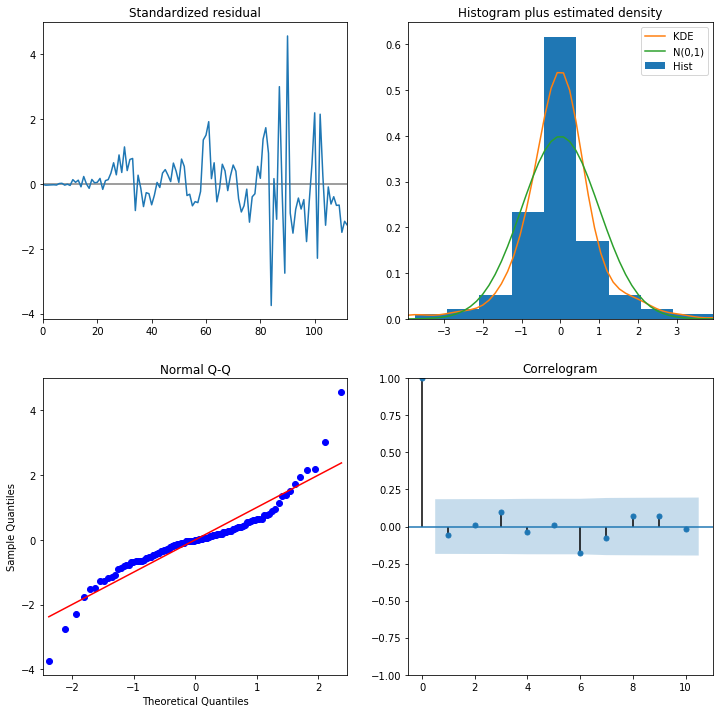

In [42]:
# Summarize residual errors for the automated grid search ARIMA model
print(randgrid_results.summary())
randgrid_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [43]:
if (notifyStatus): email_notify("ARIMA automated random search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [44]:
# Do an automated grid search of ARIMA parameters
if (seasonal_freq == 0):
    autogrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = False, stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)
else:
    autogrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = True, m = seasonal_freq, start_P = start_P, D = start_D, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
                                     stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)

Fit ARIMA: order=(0, 1, 0); AIC=3066.840, BIC=3072.295, Fit time=0.006 seconds
Fit ARIMA: order=(0, 1, 1); AIC=3058.372, BIC=3066.555, Fit time=0.149 seconds
Fit ARIMA: order=(0, 1, 2); AIC=3033.683, BIC=3044.592, Fit time=0.396 seconds
Fit ARIMA: order=(0, 1, 3); AIC=3034.795, BIC=3048.432, Fit time=0.238 seconds
Fit ARIMA: order=(0, 1, 4); AIC=3035.593, BIC=3051.957, Fit time=1.119 seconds
Fit ARIMA: order=(0, 1, 5); AIC=3036.846, BIC=3055.938, Fit time=2.327 seconds
Fit ARIMA: order=(1, 1, 0); AIC=3066.365, BIC=3074.547, Fit time=0.030 seconds
Fit ARIMA: order=(1, 1, 1); AIC=3045.290, BIC=3056.199, Fit time=0.391 seconds
Fit ARIMA: order=(1, 1, 2); AIC=3034.485, BIC=3048.122, Fit time=0.299 seconds
Fit ARIMA: order=(1, 1, 3); AIC=3034.743, BIC=3051.108, Fit time=1.245 seconds
Fit ARIMA: order=(1, 1, 4); AIC=3037.122, BIC=3056.214, Fit time=0.647 seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0); AIC=3045.055, BIC=3055.965, Fit time

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  113
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1512.841
Method:                       css-mle   S.D. of innovations         156844.013
Date:                Wed, 11 Dec 2019   AIC                           3033.683
Time:                        20:33:15   BIC                           3044.592
Sample:                             1   HQIC                          3038.110
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2494.8629   2608.516      0.956      0.341   -2617.734    7607.460
ma.L1.D.y     -0.2308      0.087     -2.651      0.009      -0.401      -0.060
ma.L2.D.y     -0.6101      0.089     -6.872      0.0

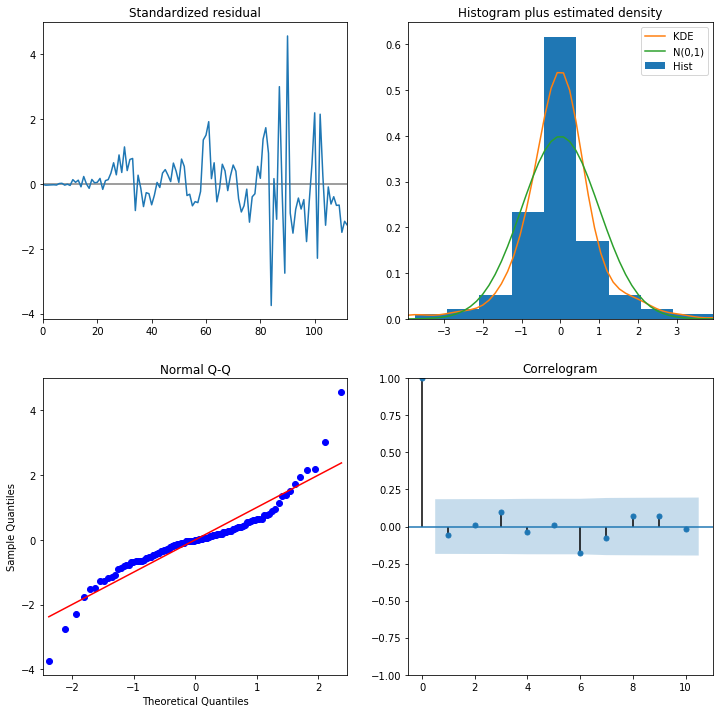

In [45]:
# Summarize residual errors for the automated grid search ARIMA model
print(autogrid_results.summary())
autogrid_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [46]:
if (notifyStatus): email_notify("ARIMA automated grid search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Evaluate the Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

In [51]:
# Set the ARIMA order parameters for validation and forecasting
final_ns_order = stepwise_results.order
# final_ns_order = randgrid_results.order
# final_ns_order = autogrid_results.order
# final_ns_order = best_ns_cfg
if (seasonal_freq != 0):
    final_ss_order = stepwise_results.seasonal_order
#     final_ss_order = randgrid_results.seasonal_order
#     final_ss_order = autogrid_results.seasonal_order
#     final_ss_order = best_ss_cfg
    print("Final Non-season order:", final_ns_order, 'Final Seasonal Order:', final_ss_order)
else:
    print("Final Non-season order:", final_ns_order)

Final Non-season order: (0, 1, 2)


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                 values   No. Observations:                  143
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1888.541
Date:                Wed, 11 Dec 2019   AIC                           3783.082
Time:                        20:33:17   BIC                           3791.949
Sample:                    01-01-1820   HQIC                          3786.685
                         - 01-01-1962                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1946      0.059     -3.281      0.001      -0.311      -0.078
ma.L2         -0.5586      0.055    -10.140      0.000      -0.667      -0.451
sigma2      2.302e+10   1.43e-12   1.61e+22      0.0

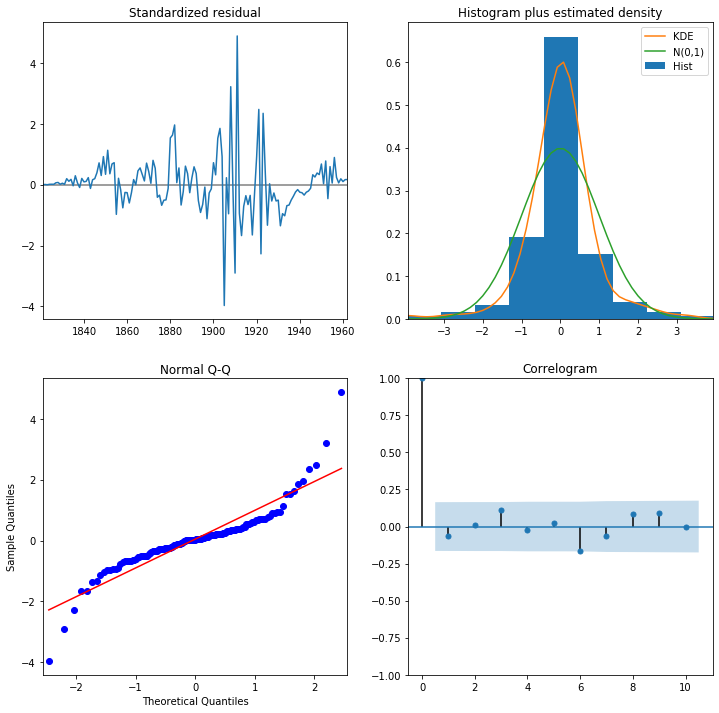

In [52]:
# Summarize residual errors for the final ARIMA model
if (seasonal_freq != 0):
    final_model = SARIMAX(time_series, order=final_ns_order, seasonal_order=final_ss_order)
else:
    final_model = SARIMAX(time_series, order=final_ns_order)
final_results = final_model.fit(disp = False)
print(final_results.summary())
final_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [53]:
if (notifyStatus): email_notify("Model Fitting and Evaluation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize Model

After models have been developed and a final model selected, it must be validated and finalized. Validation is an optional part of the process, but one that provides a ‘last check’ to ensure we have not fooled or lied to ourselves.

In [54]:
if (notifyStatus): email_notify("Model Finalization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Validation via In-sample Data

In [55]:
validate_forecast = final_results.get_prediction(start = -test_size)
mean_validate_forecast = validate_forecast.predicted_mean
validate_confidence_intervals = validate_forecast.conf_int()

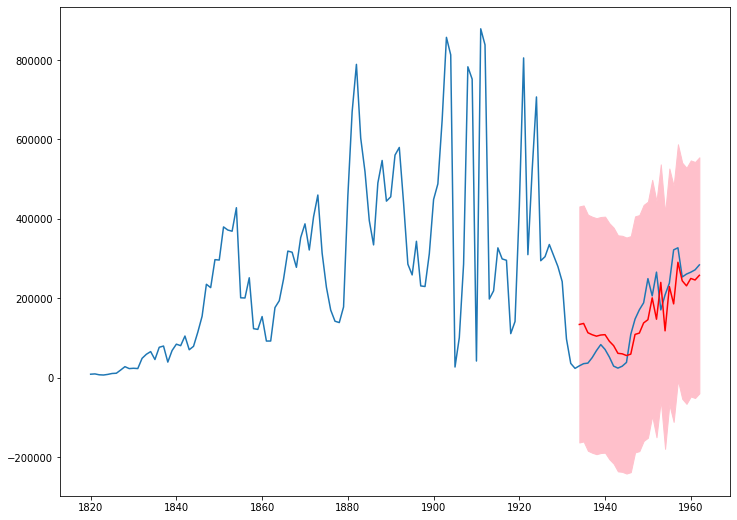

In [56]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_validate_forecast.index, mean_validate_forecast.values, color='red', label='forecast')
plt.fill_between(validate_confidence_intervals.index, validate_confidence_intervals[lower_bound], 
                 validate_confidence_intervals[upper_bound], color='pink')
plt.show()

In [57]:
# Evaluate RMSE for the validation data
y_test = time_series[-test_size:]
predictions = mean_validate_forecast.values
for i in range(y_test.shape[0]):
    print(y_test.index[i], ' | ', y_test.iloc[i,0], ' | ', predictions[i])
print('RMSE from the validation data is: %.3f' % math.sqrt(mean_squared_error(y_test, predictions)))

1934-01-01 00:00:00  |  29470  |  133727.01213707894
1935-01-01 00:00:00  |  34956  |  136260.84893661097
1936-01-01 00:00:00  |  36329  |  112906.56284870901
1937-01-01 00:00:00  |  50244  |  107819.08854175755
1938-01-01 00:00:00  |  67895  |  104223.74584859362
1939-01-01 00:00:00  |  82998  |  107125.73058102763
1940-01-01 00:00:00  |  70756  |  107986.28483159225
1941-01-01 00:00:00  |  51776  |  91478.143434047
1942-01-01 00:00:00  |  28781  |  80298.32001936698
1943-01-01 00:00:00  |  23725  |  60983.08837600365
1944-01-01 00:00:00  |  28551  |  59752.633529805076
1945-01-01 00:00:00  |  38119  |  55434.845127390174
1946-01-01 00:00:00  |  108721  |  58917.793827538444
1947-01-01 00:00:00  |  147292  |  108703.21954598346
1948-01-01 00:00:00  |  170570  |  111962.96399163538
1949-01-01 00:00:00  |  188317  |  137610.34882096344
1950-01-01 00:00:00  |  249187  |  145712.20003126506
1951-01-01 00:00:00  |  205717  |  200727.94511484416
1952-01-01 00:00:00  |  265520  |  146944.254

### 5.b) Forecasting Out-of-Sample Data

In [58]:
final_forecast = final_results.get_forecast(steps = test_size)
mean_final_forecast = final_forecast.predicted_mean
final_confidence_intervals = final_forecast.conf_int()
print("The forecasted values are:\n\n", mean_final_forecast)

The forecasted values are:

 1963-01-01    264369.724630
1964-01-01    249724.053186
1965-01-01    249724.053186
1966-01-01    249724.053186
1967-01-01    249724.053186
1968-01-01    249724.053186
1969-01-01    249724.053186
1970-01-01    249724.053186
1971-01-01    249724.053186
1972-01-01    249724.053186
1973-01-01    249724.053186
1974-01-01    249724.053186
1975-01-01    249724.053186
1976-01-01    249724.053186
1977-01-01    249724.053186
1978-01-01    249724.053186
1979-01-01    249724.053186
1980-01-01    249724.053186
1981-01-01    249724.053186
1982-01-01    249724.053186
1983-01-01    249724.053186
1984-01-01    249724.053186
1985-01-01    249724.053186
1986-01-01    249724.053186
1987-01-01    249724.053186
1988-01-01    249724.053186
1989-01-01    249724.053186
1990-01-01    249724.053186
1991-01-01    249724.053186
Freq: AS-JAN, dtype: float64


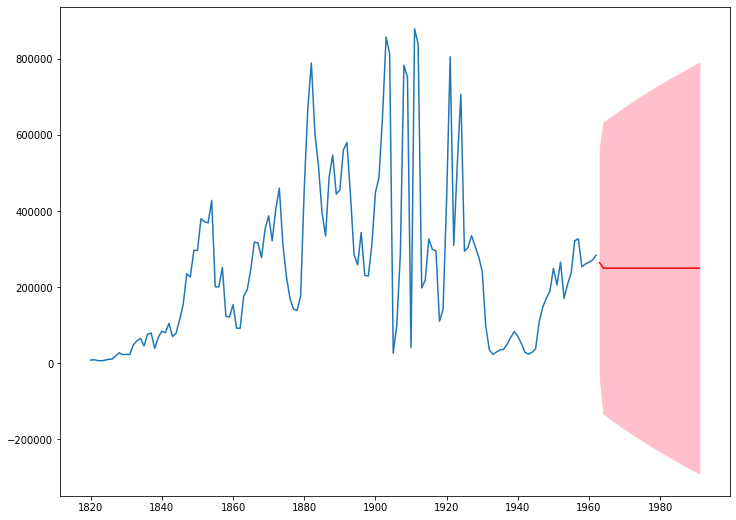

In [59]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_final_forecast.index, mean_final_forecast.values, color='red', label='forecast')
plt.fill_between(final_confidence_intervals.index, final_confidence_intervals[lower_bound], 
                 final_confidence_intervals[upper_bound], color='pink')
plt.show()

In [60]:
if (notifyStatus): email_notify("Model Finalization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [61]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:16.939071
